# FreightDispatchSimulator.jl - Simulation Examples

This notebook demonstrates the freight dispatch simulation capabilities with visualizations comparing different dispatch strategies.

## Setup

**Important:** To avoid long setup times, start Jupyter with the project environment activated:

```bash
cd /path/to/freight-dispatch-simulator
julia --project=. -e 'using IJulia; notebook(dir=pwd())'
```

This way, the Julia kernel will automatically use the correct environment and packages will already be precompiled.

Alternatively, if using VS Code, open the project folder first, then open the notebook.

In [1]:
# Activate project environment
# Note: Run this notebook from the project root directory
import Pkg
Pkg.activate(pwd())  # Use current working directory
Pkg.instantiate()    # Quick if already instantiated
println("✓ Project environment activated")

  Activating project at `~/projects/freight-dispatch-simulator`


✓ Project environment activated


In [2]:
using FreightDispatchSimulator
using CSV, DataFrames
using Plots
using Statistics

# Set plot defaults
gr()
default(size=(800, 500), legend=:best)

## Load Test Data

We'll use the test data provided with the package to run our simulations.

In [3]:
# Load freight and vehicle data
freights_df = CSV.read("data/test0/freights.csv", DataFrame)
vehicles_df = CSV.read("data/test0/vehicles.csv", DataFrame)

println("Freights:")
display(freights_df)
println("\nVehicles:")
display(vehicles_df)

Freights:


Row,id,weight_kg,pickup_lat,pickup_lon,delivery_lat,delivery_lon,pickup_time,delivery_time
,String3,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,F1,100.0,40.71,-74.01,34.05,-118.24,0.0,10.0
2,F2,200.0,37.77,-122.42,41.87,-87.62,5.0,15.0



Vehicles:


Row,id,start_lat,start_lon,capacity_kg,speed_km_per_hour
,String3,Float64,Float64,Float64,Float64
1,V1,40.71,-74.01,1000.0,60.0
2,V2,37.77,-122.42,2000.0,80.0


## Understanding Dispatch Strategies

The simulator implements four **greedy heuristic** dispatch strategies. Each processes freights sequentially and assigns to the best available vehicle without backtracking or lookahead.

### Strategy Overview

| Strategy | Selection Criterion | Code Location |
|----------|---------------------|---------------|
| **FCFS** | First available vehicle with capacity | `strategies.jl:78-90` |
| **Cost** | Closest vehicle to pickup | `strategies.jl:92-114` |
| **Distance** | Shortest total route (pickup + delivery + return) | `strategies.jl:116-146` |
| **OverallCost** | Fastest route completion (accounts for speed) | `strategies.jl:148-179` |

### Important Limitations

These are **greedy heuristics**, not optimal solutions:
- Process freights one at a time in arrival order
- Make locally optimal decisions without global optimization
- Cannot reassign or backtrack
- Fast but not guaranteed to find the best overall solution

For true optimization approaches (MILP, metaheuristics), see the Future Work section in README.md.

Let's compare these strategies!

## Scenario 1: Comparing Dispatch Strategies

Let's run simulations with all four dispatch strategies and compare their performance.

In [4]:
# Define all strategies
strategies = [
    ("FCFS", FCFSStrategy()),
    ("Cost", CostStrategy()),
    ("Distance", DistanceStrategy()),
    ("OverallCost", OverallCostStrategy())
]

# Store results for comparison
results = Dict()

# Run simulations for each strategy
for (name, strategy) in strategies
    println("\n" * "="^60)
    println("Running simulation with $name strategy...")
    println("="^60)
    
    # Reload data for each simulation
    freights = CSV.read("data/test0/freights.csv", DataFrame)
    vehicles = CSV.read("data/test0/vehicles.csv", DataFrame)
    
    freight_results, vehicle_aggregates = Simulation(
        freights,
        vehicles,
        3600.0,
        strategy
    )
    
    results[name] = (freight_results, vehicle_aggregates)
    
    println("\n$name Results Summary:")
    println("  Total freights: ", nrow(freight_results))
    println("  Successful deliveries: ", sum(freight_results.success))
    println("  Total distance (all vehicles): ", round(sum(vehicle_aggregates.total_distance_km), digits=2), " km")
    println("  Average utilization: ", round(mean(vehicle_aggregates.utilization_rate) * 100, digits=2), "%")
end


Running simulation with FCFS strategy...
Starting simulation...
Running simulation until time: 3615.0 seconds
Dispatcher: Starting dispatch for 2 freights
Dispatcher: Assigning freight F1 to vehicle V2
Dispatcher: Assigning freight F2 to vehicle V1
Dispatcher: All freights processed
Simulation completed. Processed 2 freights with 2 vehicles.

FCFS Results Summary:
  Total freights: 2
  Successful deliveries: 2
  Total distance (all vehicles): 16881.68 km
  Average utilization: 12220.59%

Running simulation with Cost strategy...
Starting simulation...
Running simulation until time: 3615.0 seconds
Dispatcher: Starting dispatch for 2 freights
Dispatcher: Assigning freight F1 to vehicle V1
Dispatcher: Assigning freight F2 to vehicle V2
Dispatcher: All freights processed
Simulation completed. Processed 2 freights with 2 vehicles.

Cost Results Summary:
  Total freights: 2
  Successful deliveries: 2
  Total distance (all vehicles): 13842.43 km
  Average utilization: 10248.49%

Running simul

## Visualization 1: Total Distance by Strategy

Compare the total distance traveled by all vehicles under each dispatch strategy.

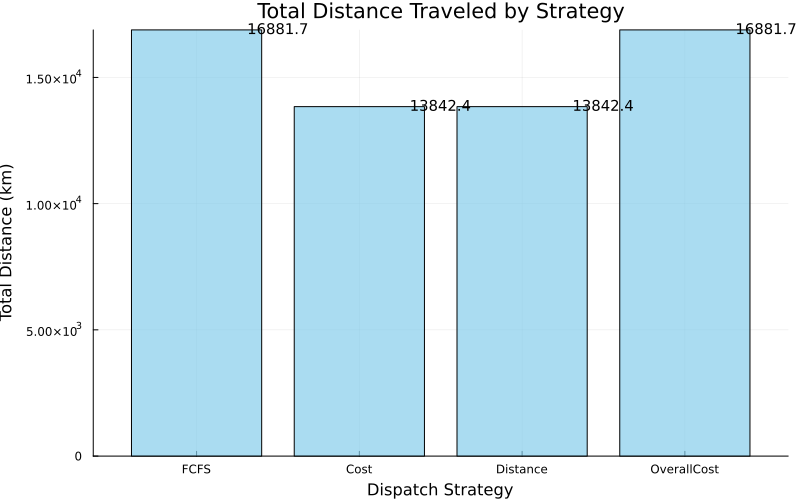

In [5]:
# Extract total distances
strategy_names = [name for (name, _) in strategies]
total_distances = [sum(results[name][2].total_distance_km) for name in strategy_names]

# Create bar plot
bar(strategy_names, total_distances,
    title="Total Distance Traveled by Strategy",
    xlabel="Dispatch Strategy",
    ylabel="Total Distance (km)",
    color=:skyblue,
    legend=false,
    grid=true,
    fillalpha=0.7
)

# Add value labels on bars
for (i, dist) in enumerate(total_distances)
    annotate!(i, dist + 50, text(string(round(dist, digits=1)), 10))
end

plot!()

## Visualization 2: Vehicle Utilization Rates

Compare how efficiently each strategy utilizes the available vehicles.

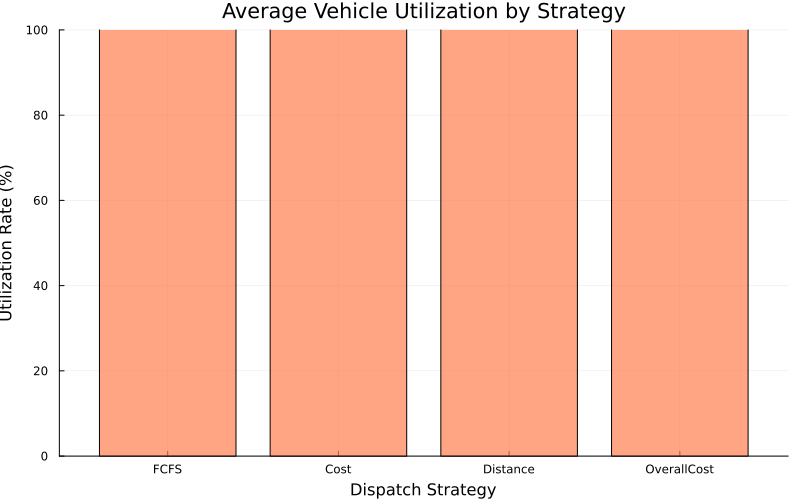

In [6]:
# Extract utilization rates
avg_utilizations = [mean(results[name][2].utilization_rate) * 100 for name in strategy_names]

# Create bar plot
bar(strategy_names, avg_utilizations,
    title="Average Vehicle Utilization by Strategy",
    xlabel="Dispatch Strategy",
    ylabel="Utilization Rate (%)",
    color=:coral,
    legend=false,
    grid=true,
    fillalpha=0.7,
    ylims=(0, 100)
)

# Add value labels
for (i, util) in enumerate(avg_utilizations)
    annotate!(i, util + 3, text(string(round(util, digits=1)) * "%", 10))
end

plot!()

# Extract completion times for successful deliveries
completion_times_by_strategy = []

for name in strategy_names
    freight_results = results[name][1]
    successful = freight_results[freight_results.success .== true, :]
    
    if nrow(successful) > 0
        push!(completion_times_by_strategy, successful.completion_time)
    else
        push!(completion_times_by_strategy, [0.0])
    end
end

# Create scatter plot showing completion times
p = plot(title="Completion Times by Strategy",
         xlabel="Strategy",
         ylabel="Completion Time (seconds)",
         legend=false,
         grid=true,
         size=(800, 500))

colors = [:blue, :green, :orange, :purple]

for (i, (name, times)) in enumerate(zip(strategy_names, completion_times_by_strategy))
    # Plot points with jitter for visibility
    x_coords = fill(i, length(times)) .+ 0.1 .* randn(length(times))
    scatter!(x_coords, times,
             color=colors[i],
             alpha=0.6,
             markersize=8,
             label=name)
    
    # Add mean line
    mean_time = mean(times)
    plot!([i-0.2, i+0.2], [mean_time, mean_time],
          color=colors[i],
          linewidth=3,
          alpha=0.8)
end

xticks!(1:length(strategy_names), strategy_names)
plot!()

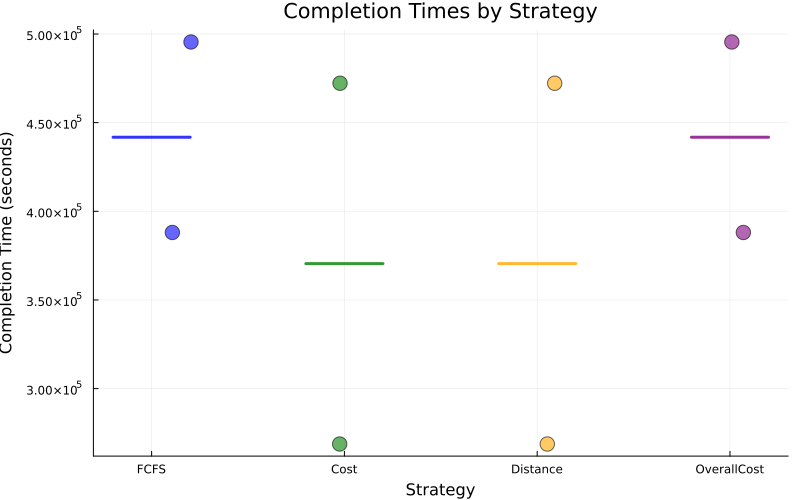

In [7]:
# Extract completion times for successful deliveries
completion_times_by_strategy = []

for name in strategy_names
    freight_results = results[name][1]
    successful = freight_results[freight_results.success .== true, :]
    
    if nrow(successful) > 0
        push!(completion_times_by_strategy, successful.completion_time)
    else
        push!(completion_times_by_strategy, [0.0])
    end
end

# Create scatter plot showing completion times
p = plot(title="Completion Times by Strategy",
         xlabel="Strategy",
         ylabel="Completion Time (seconds)",
         legend=false,
         grid=true,
         size=(800, 500))

colors = [:blue, :green, :orange, :purple]

for (i, (name, times)) in enumerate(zip(strategy_names, completion_times_by_strategy))
    # Plot points with jitter for visibility
    x_coords = fill(i, length(times)) .+ 0.1 .* randn(length(times))
    scatter!(x_coords, times,
             color=colors[i],
             alpha=0.6,
             markersize=8,
             label=name)
    
    # Add mean line
    mean_time = mean(times)
    plot!([i-0.2, i+0.2], [mean_time, mean_time],
          color=colors[i],
          linewidth=3,
          alpha=0.8)
end

xticks!(1:length(strategy_names), strategy_names)
plot!()

## Visualization 4: Success Rate Comparison

Show the success rate (percentage of freights successfully delivered) for each strategy.

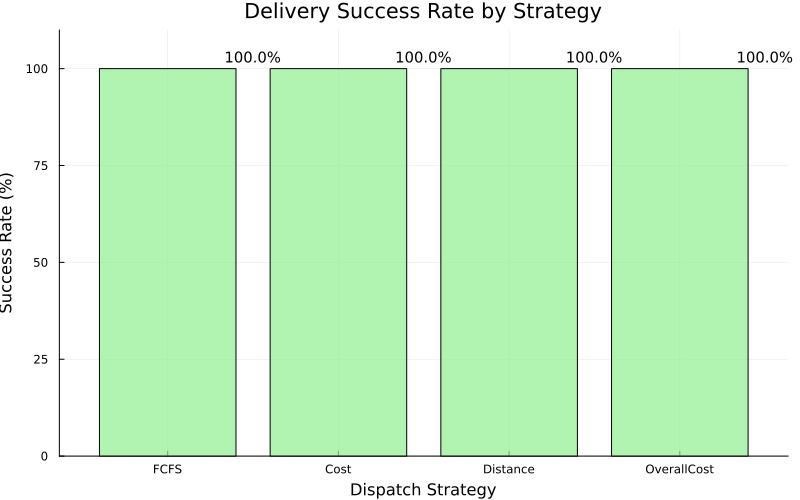

In [8]:
# Calculate success rates
success_rates = [mean(results[name][1].success) * 100 for name in strategy_names]

bar(strategy_names, success_rates,
    title="Delivery Success Rate by Strategy",
    xlabel="Dispatch Strategy",
    ylabel="Success Rate (%)",
    color=:lightgreen,
    legend=false,
    grid=true,
    fillalpha=0.7,
    ylims=(0, 110)
)

# Add value labels
for (i, rate) in enumerate(success_rates)
    annotate!(i, rate + 3, text(string(round(rate, digits=1)) * "%", 10))
end

plot!()

## Visualization 5: Distance per Vehicle

Compare the distance traveled by each vehicle across different strategies.

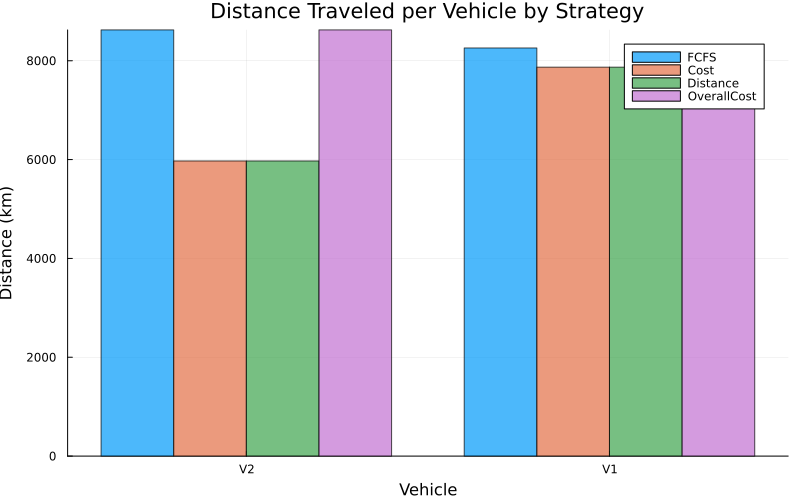

In [9]:
# Create grouped bar chart
p = plot(title="Distance Traveled per Vehicle by Strategy",
         xlabel="Vehicle",
         ylabel="Distance (km)",
         legend=:topright,
         grid=true)

vehicle_ids = unique(results[strategy_names[1]][2].vehicle_id)
x_positions = 1:length(vehicle_ids)
bar_width = 0.2

for (i, name) in enumerate(strategy_names)
    vehicle_agg = results[name][2]
    distances = [vehicle_agg[vehicle_agg.vehicle_id .== vid, :total_distance_km][1] 
                 for vid in vehicle_ids]
    
    bar!(x_positions .+ (i-2.5)*bar_width, distances,
         bar_width=bar_width,
         label=name,
         alpha=0.7)
end

xticks!(x_positions, vehicle_ids)
plot!()

## Visualization 6: Freights Handled per Vehicle

Show the workload distribution across vehicles for each strategy.

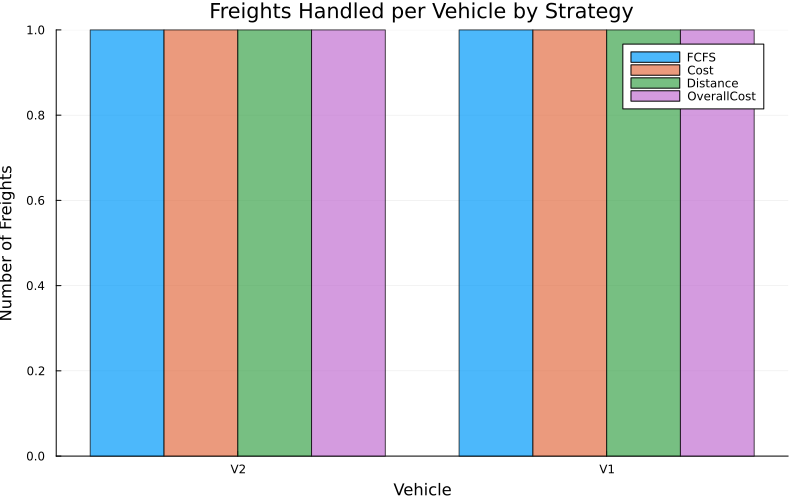

In [10]:
# Create grouped bar chart for freights handled
p = plot(title="Freights Handled per Vehicle by Strategy",
         xlabel="Vehicle",
         ylabel="Number of Freights",
         legend=:topright,
         grid=true)

for (i, name) in enumerate(strategy_names)
    vehicle_agg = results[name][2]
    freights_handled = [vehicle_agg[vehicle_agg.vehicle_id .== vid, :total_freights_handled][1] 
                        for vid in vehicle_ids]
    
    bar!(x_positions .+ (i-2.5)*bar_width, freights_handled,
         bar_width=bar_width,
         label=name,
         alpha=0.7)
end

xticks!(x_positions, vehicle_ids)
plot!()

## Visualization 7: Combined Metrics Dashboard

Create a comprehensive dashboard showing all key metrics in one view.

## Generate Interactive Route Map

To create an interactive HTML map, we need to enrich the results with pickup/delivery coordinates from the original freight data.

## Detailed Results Table

Let's examine the detailed results for each strategy.

In [11]:
println("\nDetailed Strategy Comparison")
println("="^80)

comparison_df = DataFrame(
    Strategy = strategy_names,
    Total_Distance_km = round.(total_distances, digits=2),
    Avg_Utilization_pct = round.(avg_utilizations, digits=2),
    Success_Rate_pct = round.(success_rates, digits=2),
)

display(comparison_df)

# Find the best strategy for each metric
println("\nBest Performance by Metric:")
println("  Lowest Distance: ", strategy_names[argmin(total_distances)])
println("  Highest Utilization: ", strategy_names[argmax(avg_utilizations)])
println("  Best Success Rate: ", strategy_names[argmax(success_rates)])


Detailed Strategy Comparison


Row,Strategy,Total_Distance_km,Avg_Utilization_pct,Success_Rate_pct
,String,Float64,Float64,Float64
1,FCFS,16881.7,12220.6,100.0
2,Cost,13842.4,10248.5,100.0
3,Distance,13842.4,10248.5,100.0
4,OverallCost,16881.7,12220.6,100.0



Best Performance by Metric:
  Lowest Distance: Cost
  Highest Utilization: FCFS
  Best Success Rate: FCFS


In [12]:
# Select a strategy to visualize
best_strategy = "Distance"  # Change this to compare different strategies

freight_results = results[best_strategy][1]
vehicles = CSV.read("data/test0/vehicles.csv", DataFrame)
freights_original = CSV.read("data/test0/freights.csv", DataFrame)

# Join results with original freight data to get coordinates
freight_with_coords = leftjoin(freight_results, freights_original, on = :freight_id => :id, makeunique=true)

# Generate the route map
output_file = "route_map_$(best_strategy).html"
generate_route_map(freight_with_coords, vehicles, output_file)

println("Route map generated: $output_file")
println("Open this file in a web browser to view the interactive map with:")
println("  - Vehicle routes in different colors")
println("  - ⚫ Pickup circles (color-coded by vehicle)")
println("  - ■ Delivery squares (color-coded by vehicle)")
println("  - ⬡ Vehicle bases (hexagons, color-coded)")
println("  - ❌ Failed freights (red X marks)")

WebIO._IJuliaInit()

[ Info: Precompiling IJuliaExt [ca55ebba-d40a-59bc-9445-d114519c28be] 
[ Info: Precompiling IJuliaExt [7e890bae-9aa3-53bb-baa1-af4d530ff287] 


Interactive map saved to: route_map_Distance.html
Route map generated: route_map_Distance.html
Open this file in a web browser to view the interactive map with:
  - Vehicle routes in different colors
  - ⚫ Pickup circles (color-coded by vehicle)
  - ■ Delivery squares (color-coded by vehicle)
  - ⬡ Vehicle bases (hexagons, color-coded)
  - ❌ Failed freights (red X marks)


In [13]:
# Alternative approach: Select a different strategy to visualize
best_strategy = "Cost"  # Change this to compare different strategies

freight_results = results[best_strategy][1]
vehicles = CSV.read("data/test0/vehicles.csv", DataFrame)
freights_original = CSV.read("data/test0/freights.csv", DataFrame)

# Join results with original freight data to get coordinates
freight_with_coords = leftjoin(freight_results, freights_original, on = :freight_id => :id, makeunique=true)

# Generate the route map
output_file = "route_map_$(best_strategy).html"
generate_route_map(freight_with_coords, vehicles, output_file)

println("Route map generated: $output_file")
println("Open this file in a web browser to view the interactive map")

Interactive map saved to: route_map_Cost.html
Route map generated: route_map_Cost.html
Open this file in a web browser to view the interactive map


## Detailed Results Table

Let's examine the detailed results for each strategy.

### Key Insights

Compare how strategies perform across different scenarios:

**US Scenarios:**
- **Urban deliveries** (short distances): Strategies may show similar performance since routes are short
- **Long-haul** (cross-country): Distance and OverallCost strategies should show more differentiation
- **Mixed** scenarios: Tests strategy robustness across varied freight types

**EU Scenarios:**
- **EU Urban (NL)**: Netherlands cities - compact geography, shorter routes
- **EU Long-haul**: Cross-Europe - longer distances similar to US long-haul but with different road networks
- **Iberia & Benelux**: Regional scenarios with moderate distances

The greedy heuristics provide fast, reasonable solutions but differences between strategies become more apparent with larger, more complex problems and longer distances.

### Visualization: Strategy Performance Across Datasets

In [14]:
# Define datasets to test (US and EU scenarios)
datasets = [
    ("US Urban", "data/urban"),
    ("US Long-haul", "data/longhaul"),
    ("US Mixed", "data/mixed"),
    ("EU Urban (NL)", "data/eu_urban"),
    ("EU Long-haul", "data/eu_longhaul"),
    ("Iberia", "data/iberia"),
    ("Benelux", "data/benelux")
]

# Store results for each dataset
dataset_results = Dict()

for (dataset_name, dataset_path) in datasets
    println("\n" * "="^70)
    println("Testing $dataset_name Dataset")
    println("="^70)
    
    # Load dataset
    freights = CSV.read("$dataset_path/freights.csv", DataFrame)
    vehicles = CSV.read("$dataset_path/vehicles.csv", DataFrame)
    
    println("Dataset: $(nrow(freights)) freights, $(nrow(vehicles)) vehicles")
    
    # Test all strategies
    strategy_results = Dict()
    
    for (name, strategy) in strategies
        freight_results, vehicle_aggregates = Simulation(
            freights, vehicles, 3600.0, strategy
        )
        strategy_results[name] = (freight_results, vehicle_aggregates)
        
        total_dist = sum(vehicle_aggregates.total_distance_km)
        success_rate = mean(freight_results.success) * 100
        
        println("  $name: $(round(total_dist, digits=1)) km, $(round(success_rate, digits=1))% success")
    end
    
    dataset_results[dataset_name] = strategy_results
end


Testing US Urban Dataset
Dataset: 15 freights, 5 vehicles
Starting simulation...
Running simulation until time: 36000.0 seconds
Dispatcher: Starting dispatch for 15 freights
Dispatcher: Assigning freight F1 to vehicle V5
Dispatcher: Assigning freight F2 to vehicle V3
Dispatcher: Assigning freight F3 to vehicle V5
Dispatcher: Assigning freight F4 to vehicle V3
Dispatcher: Assigning freight F5 to vehicle V5
Dispatcher: Assigning freight F6 to vehicle V3
Dispatcher: Assigning freight F7 to vehicle V5
Dispatcher: Assigning freight F8 to vehicle V3
Dispatcher: Assigning freight F9 to vehicle V5
Dispatcher: Assigning freight F10 to vehicle V3
Dispatcher: Assigning freight F11 to vehicle V5
Dispatcher: Assigning freight F12 to vehicle V3
Dispatcher: Assigning freight F13 to vehicle V3
Dispatcher: Assigning freight F14 to vehicle V5
Dispatcher: Assigning freight F15 to vehicle V3
Dispatcher: All freights processed
Simulation completed. Processed 15 freights with 5 vehicles.
  FCFS: 472.2 km, 

## Scenario 2: Realistic Dataset Comparisons

Let's test the strategies on seven realistic scenarios across US and EU regions:

**US Scenarios:**
- **US Urban**: NYC area deliveries (short distances, many freights)
- **US Long-haul**: Cross-country USA (long distances, fewer freights)
- **US Mixed**: Combination of urban and long-haul deliveries

**EU Scenarios:**
- **EU Urban (NL)**: Netherlands cities - Amsterdam, Rotterdam, Utrecht, Groningen
- **EU Long-haul**: Cross-Europe routes - Lisbon to Berlin, Madrid to Amsterdam, etc.
- **Iberia**: Spain & Portugal regional - Madrid, Barcelona, Lisbon, Seville
- **Benelux**: Netherlands, Belgium, Luxembourg - Amsterdam, Brussels, Rotterdam

# Load larger test dataset (Iberian Peninsula routes)
freights_large = CSV.read("data/test1/freights.csv", DataFrame)
vehicles_large = CSV.read("data/test1/vehicles.csv", DataFrame)

println("Large dataset (Iberian Peninsula):")
println("  Freights: ", nrow(freights_large))
println("  Vehicles: ", nrow(vehicles_large))

# Run with Distance strategy (typically best)
println("\nRunning simulation...")
freight_results_large, vehicle_aggregates_large = Simulation(
    freights_large,
    vehicles_large,
    360000.0,  # Larger buffer for longer time windows
    DistanceStrategy()
)

println("\nLarge Dataset Results:")
println("  Successful deliveries: ", sum(freight_results_large.success), " / ", nrow(freight_results_large))
println("  Total distance: ", round(sum(vehicle_aggregates_large.total_distance_km), digits=2), " km")
println("  Average utilization: ", round(mean(vehicle_aggregates_large.utilization_rate) * 100, digits=2), "%")

In [15]:
# Load larger test dataset
freights_large = CSV.read("data/test1/freights.csv", DataFrame)
vehicles_large = CSV.read("data/test1/vehicles.csv", DataFrame)

println("Large dataset:")
println("  Freights: ", nrow(freights_large))
println("  Vehicles: ", nrow(vehicles_large))

# Run with Distance strategy (typically best)
println("\nRunning simulation...")
freight_results_large, vehicle_aggregates_large = Simulation(
    freights_large,
    vehicles_large,
    3600.0,
    DistanceStrategy()
)

println("\nLarge Dataset Results:")
println("  Successful deliveries: ", sum(freight_results_large.success), " / ", nrow(freight_results_large))
println("  Total distance: ", round(sum(vehicle_aggregates_large.total_distance_km), digits=2), " km")
println("  Average utilization: ", round(mean(vehicle_aggregates_large.utilization_rate) * 100, digits=2), "%")

Large dataset:
  Freights: 20
  Vehicles: 15

Running simulation...
Starting simulation...
Running simulation until time: 212400.0 seconds
Dispatcher: Starting dispatch for 20 freights
Dispatcher: Assigning freight F1 to vehicle V1
Dispatcher: Assigning freight F2 to vehicle V2
Dispatcher: Assigning freight F3 to vehicle V3
Dispatcher: Assigning freight F4 to vehicle V8
Dispatcher: Assigning freight F5 to vehicle V9
Dispatcher: Assigning freight F6 to vehicle V6
Dispatcher: Assigning freight F7 to vehicle V15
Dispatcher: Assigning freight F8 to vehicle V12
Dispatcher: Assigning freight F9 to vehicle V13
Dispatcher: Assigning freight F10 to vehicle V14
Dispatcher: Assigning freight F11 to vehicle V11
Dispatcher: Assigning freight F12 to vehicle V5
Dispatcher: Assigning freight F13 to vehicle V3
Dispatcher: Assigning freight F14 to vehicle V14
Dispatcher: Assigning freight F15 to vehicle V12
Dispatcher: Assigning freight F16 to vehicle V1
Dispatcher: Assigning freight F17 to vehicle V8
D